# Planar rectangle
## Field emission

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline
import seaborn as sns
sns.set_theme()

import os.path as path
import f90nml

# Path to simulations
filepath = './'

## Read input parameters

In [2]:
# input file
filename_input = path.join(filepath, 'input')

# Read the input file for parameters used
input_nml = f90nml.read(filename_input)

# Read the init.bin file for system parameters
#epsilon_r, m_eeff, m_heff, length_scale, time_scale, vel_scale, cur_scale, MAX_PARTICLES, MAX_EMITTERS, MAX_SECTIONS, MAX_LIFE_TIME
dt_sys = np.dtype([('epsilon_r', np.float64), \
                   ('m_eeff', np.float64), \
                   ('m_heff', np.float64), \
                   ('length_scale', np.float64), \
                   ('time_scale', np.float64), \
                   ('vel_scale', np.float64), \
                   ('cur_scale', np.float64), \
                   ('MAX_PARTICLES', np.int32), \
                   ('MAX_EMITTERS', np.int32), \
                   ('MAX_SECTIONS', np.int32), \
                   ('MAX_LIFE_TIME', np.int32) ])
filename_initbin = path.join(filepath, 'out/init.bin')
data_sys = np.memmap(filename_initbin, dtype=dt_sys, mode='r', order='F')
input_nml['system'] = dict(zip(data_sys.dtype.names, data_sys[0]))

# Print input parameters
print(input_nml)

&input
    v_s = 2000.0
    box_dim = 0.0, 0.0, 1000.0
    time_step = 0.0001
    steps = 2000
    emission_mode = 10
    nremit = 1
    image_charge = .true.
    n_ic_max = 1
    collisions = .false.
    t_temp = 293.15
    p_abs = 1.0
    emitters_dim(1:3,1) = 500.0, 500.0, 0.0
    emitters_pos(1:3,1) = -250.0, -250.0, 0.0
    emitters_type(1) = 2
    emitters_delay(1) = 0
/

&system
    max_emitters = 1
    max_life_time = 1000
    max_particles = 500000
    max_sections = 9216
    cur_scale = 1.0
    epsilon_r = 1.0
    length_scale = 1e-09
    m_eeff = 1.0
    m_heff = 1.0
    time_scale = 1e-12
    vel_scale = 1000.0000000000001
/


### Emission information

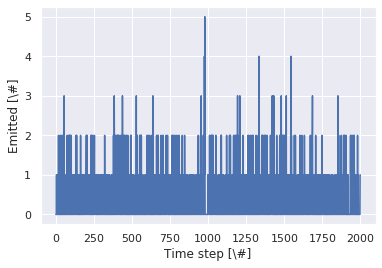

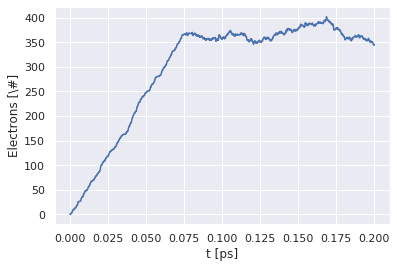

In [4]:
# Emission file
filename_emit = path.join(filepath, 'out/emitted.dt')

# Read data into a pandas dataframe
df_emit = pd.read_csv(filepath_or_buffer=filename_emit, index_col=1, delim_whitespace=True, \
                      header=None, names=['time', 'step', 'nrEmit', 'nrElec', 'nrEmit1'])

# Plot number of particles emitted per time step
plt.plot(df_emit['nrEmit'].to_numpy())
plt.xlabel('Time step [\#]')
plt.ylabel('Emitted [\#]')
plt.show()

# Plot total number of particles in the system as a function of time
plt.plot(df_emit['time'].to_numpy(), df_emit['nrElec'].to_numpy())
plt.xlabel('t [ps]')
plt.ylabel('Electrons [\#]')
plt.show()

## Current
Read ramo current and plot

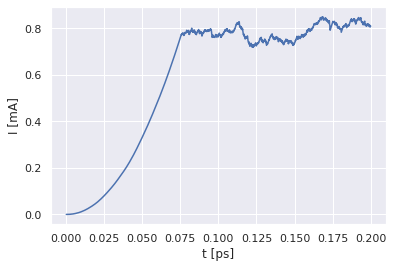

In [5]:
# Ramo current
filename_ramo = path.join(filepath, 'out/ramo_current.dt')

# Read the data into a pandas dataframe
#cur_time, step, ramo_cur, V_d, nrPart, nrElec, nrHole
df_cur = pd.read_csv(filepath_or_buffer=filename_ramo, index_col=1, delim_whitespace=True, \
                     header=None, names=['time', 'step', 'current', 'volt', 'nrPart', 'nrElec', 'nrHole', 'avg_mob', 'avg_speed', 'ramo_1', 'ramo_2'])

# Plot current in mA as a function of time in ps
plt.plot(df_cur['time'].to_numpy(), df_cur['current'].to_numpy()/1.0E-3)
plt.xlabel('t [ps]')
plt.ylabel('I [mA]')
plt.show()

## Density

### Plot emission density

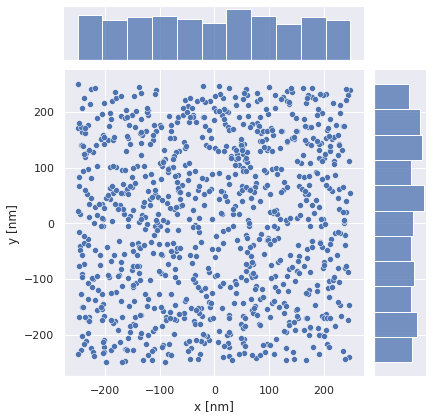

In [6]:
filename_emit_den = path.join(filepath, 'out/density_emit.bin')

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_emit_type = np.dtype([('x', np.float64), ('y', np.float64), ('emit', np.int32), ('sec', np.int32), ('id', np.int32)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_emit = np.memmap(filename_emit_den, dtype=dt_emit_type, mode='r', order='F')
    
# Read the data into dataframe
df_emit = pd.DataFrame.from_records(data=data_mem_emit, columns=data_mem_emit.dtype.names)

g = sns.jointplot(data=df_emit, x="x", y="y")
g.set_axis_labels("x [nm]", "y [nm]")

### Plot absorption density

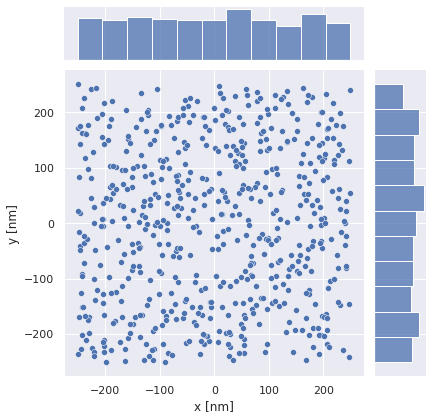

In [7]:
filename_abs = path.join(filepath, 'out/density_absorb_top.bin')

# Binary file layout
# float64 (double precision numbers)
# int32 (32bit integers)
dt_abs_type = np.dtype([('x', np.float64), ('y', np.float64), ('vx', np.float64), ('vy', np.float64), ('vz', np.float64), ('emit', np.int32), ('sec', np.int32),  ('id', np.int32)])

# Memory map the file
# mode=r (Read only)
# order=F (Fortran style array)
data_mem_abs = np.memmap(filename_abs, dtype=dt_abs_type, mode='r', order='F')
    
# Read the data into dataframe
df_abs = pd.DataFrame.from_records(data=data_mem_abs, columns=data_mem_abs.dtype.names)

h = sns.jointplot(data=df_abs, x="x", y="y")
h.set_axis_labels("x [nm]", "y [nm]")

### Emittance data

# Calculates the emittance
Input is a pandas dataframe that has columns called x and x'.

It returns the Emittance, sigma_w, sigma_wp and theta.
* emittance [units of x * x'] [nm-mrad]
* sigma_w is the semi-major axis of the ellipse [units of x]
* sigma_wp is the semi-minor axis of the ellipse [units of x']
* theta is the rotation of the ellipse [deg]

See http://uspas.fnal.gov/materials/10MIT/Emittance.pdf 
or J. Buon, "Beam phase space and emittance". \
See also USPAS notes Barletta, Spentzouris, Harms\
https://uspas.fnal.gov/materials/10MIT/MIT-Fund.shtml \
https://uspas.fnal.gov/materials/10MIT/Emittance.pdf

In [8]:
def Calc_Emittance(df_emitt, x, xp):
    sigma_x = df_emitt[x].std(ddof=0) # \sigma_x, ddof=0 means use N as normalization
    sigma_xp = df_emitt[xp].std(ddof=0) # \sigma_{x^\prime}
    cov_xxp = df_emitt.cov()[x][xp] # \sigma_x\sigma_{x^\prime}
    N = df_emitt[x].count()
    cov_xxp = cov_xxp*(N-1)/N # Use N as normalization, Pandas uses N-1
    r = df_emitt.corr(method='pearson')[x][xp]
    
    #emittance = sigma_x*sigma_xp*np.sqrt(1.0-r**2)
    emittance = np.sqrt(sigma_x**2*sigma_xp**2 - cov_xxp**2)
    
    sigma_w  = np.sqrt( 0.5*(sigma_x**2 + sigma_xp**2 + np.sqrt( (sigma_x**2 - sigma_xp**2)**2 + (2.0*cov_xxp)**2 )) )
    sigma_wp = np.sqrt( 0.5*(sigma_x**2 + sigma_xp**2 - np.sqrt( (sigma_x**2 - sigma_xp**2)**2 + (2.0*cov_xxp)**2 )) )
    
    theta = 0.5*np.arctan2(2.0*cov_xxp, (sigma_x**2 - sigma_xp**2)) # in rad
    theta = theta * 180/np.pi # Convert from rad to deg
    
    #emittance = sigma_w*sigma_wp
    
    return emittance, sigma_w, sigma_wp, theta

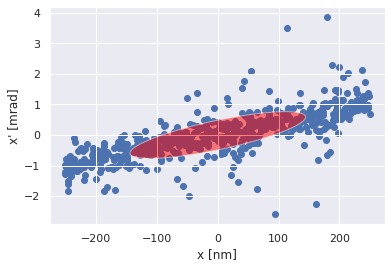

In [9]:
df_abs['v'] = np.sqrt(df_abs['vx']**2 + df_abs['vy']**2 + df_abs['vz']**2)

df_abs["x'"] = (df_abs['vx']/df_abs['vz'])/1.0E-3
df_abs['x'] = df_abs['x']

df_abs["y'"] = (df_abs['vy']/df_abs['vz'])/1.0E-3
df_abs['y'] = df_abs['y']
e_x, sw, swp, th = Calc_Emittance(df_abs, "x", "x'")
e_y, _, _, _ = Calc_Emittance(df_abs, "y", "y'")
emittance = (e_x + e_y)/2
sigma_w = sw
sigma_wp = swp
theta_ell = th

# Plot x and x'
ell_0 = Ellipse([0.0, 0.0], 2.0*sigma_w, 2.0*sigma_wp, theta_ell, zorder=1)
ax = plt.subplot(111)
ax.plot(df_abs['x'].to_numpy(), df_abs["x'"].to_numpy(), 'o', zorder=0)
plt.xlabel('x [nm]')
plt.ylabel("x' [mrad]")
ax.add_artist(ell_0)
ell_0.set_facecolor('red')
ell_0.set_alpha(0.5)
plt.show()